# Detection-of-Manipulated-and-Authentic-Images

- There are 4 dataset:
    * Dataset 1: [Link](https://www.kaggle.com/datasets/shivamardeshna/real-and-fake-images-dataset-for-image-forensics)

    * Dataset 2: [Link](https://www.kaggle.com/datasets/shivamardeshna/real-and-fake-images-dataset-for-image-forensics?select=Data+Set+2)

    * Dataset 3: [Link](https://www.kaggle.com/datasets/shivamardeshna/real-and-fake-images-dataset-for-image-forensics?select=Data+Set+3)

    * Dataset 4: [Link](https://www.kaggle.com/datasets/shivamardeshna/real-and-fake-images-dataset-for-image-forensics?select=Data+Set+4)

* The datasets is divided into three sets: training, testing, and validation. Each set contains 'real' and 'fake' images.

## Import Libraries

In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## Global Constants

In [22]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20

## Load Dataset Function

In [23]:
def load_datasets(data_path):
    print(f"\n--- Loading Data from: {data_path} ---")
    
    # Check if directories exist
    for sub in ['train', 'validation', 'test']:
        if not os.path.exists(os.path.join(data_path, sub)):
            print(f"Error: Directory '{sub}' not found in {data_path}")
            return None, None, None

    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'train'),
        labels='inferred',
        label_mode='binary',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'validation'),
        labels='inferred',
        label_mode='binary',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'test'),
        labels='inferred',
        label_mode='binary',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    # Optimize dataset performance
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds

## Build Model Function

In [24]:
def build_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Data Augmentation & Preprocessing
    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)
    x = tf.keras.layers.Rescaling(1./255)(x)

    # CNN Blocks
    # Block 1
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 2
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 3
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Block 4
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Classifier
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Train Model Function

In [25]:
def train_model(model, train_ds, val_ds, epochs=EPOCHS):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

## Plotting Function

In [26]:
def plot_history(history, dataset_name="Dataset"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{dataset_name}: Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{dataset_name}: Training and Validation Loss')
    
    plt.show()

## Evaluate Model Function

In [27]:
def evaluate_model(model, test_ds):
    print("\n--- Evaluating Model ---")
    
    # 1. Basic Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    # 2. Get predictions for detailed metrics
    y_pred = []
    y_true = []
    
    # Iterate over the test dataset to extract labels and predictions
    # Note: test_ds is not shuffled, so order is preserved
    for images, labels in test_ds:
        y_true.extend(labels.numpy().flatten())
        preds = model.predict(images, verbose=0)
        y_pred.extend(preds.flatten().round())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 3. Classification Report
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Real (0)', 'Fake (1)']))

    # 4. Confusion Matrix
    print('Confusion Matrix:')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Function Pipeline

In [28]:
def run_experiment(data_path, dataset_name="Dataset"):
    print(f"==========================================")
    print(f"STARTING EXPERIMENT: {dataset_name}")
    print(f"==========================================")

    # 1. Load Data
    train_ds, val_ds, test_ds = load_datasets(data_path)
    
    if train_ds is None: 
        print("Skipping due to data loading error.")
        return

    # 2. Build Model
    model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model.summary()

    # 3. Train
    history = train_model(model, train_ds, val_ds)

    # 4. Visualize Training
    plot_history(history, dataset_name)

    # 5. Evaluate
    evaluate_model(model, test_ds)
    
    return model, history

## Define Paths

In [29]:
path_dataset_1 = '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 1/Data Set 1'
path_dataset_2 = '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 2/Data Set 2'
path_dataset_3 = '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 3/Data Set 3'
path_dataset_4 = '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 4/Data Set 4'

# EXECUTION

STARTING EXPERIMENT: Dataset 1

--- Loading Data from: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 1/Data Set 1 ---
Found 40002 files belonging to 2 classes.


I0000 00:00:1764775034.393256      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 12360 files belonging to 2 classes.
Found 5227 files belonging to 2 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,947,841 (129.50 MB)

 Trainable params: 33,945,857 (129.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


E0000 00:00:1764775065.101023      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764775066.723839     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 177s 135ms/step - accuracy: 0.6167 - loss: 0.7704 - val_accuracy: 0.5076 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 2/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.8136 - loss: 0.4027 - val_accuracy: 0.8201 - val_loss: 0.4039 - learning_rate: 0.0010
Epoch 3/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.8712 - loss: 0.2977 - val_accuracy: 0.7901 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 4/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.8863 - loss: 0.2630 - val_accuracy: 0.8712 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 5/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.9029 - loss: 0.2278 - val_accuracy: 0.7195 - val_loss: 0.6543 - learning_rate: 0.0010
Epoch 6/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.9047 - loss: 0.2268 - val_accuracy: 0.9260 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 7/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - acc

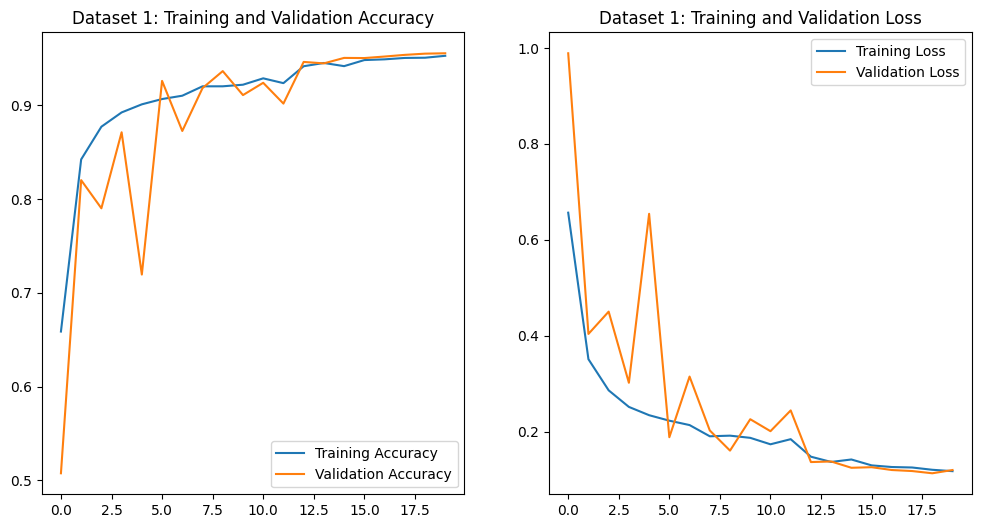


--- Evaluating Model ---
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.8132 - loss: 0.4866
Test Loss: 0.6067
Test Accuracy: 0.7961

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.75      0.88      0.81      2623
    Fake (1)       0.86      0.71      0.78      2604

    accuracy                           0.80      5227
   macro avg       0.80      0.80      0.79      5227
weighted avg       0.80      0.80      0.79      5227

Confusion Matrix:


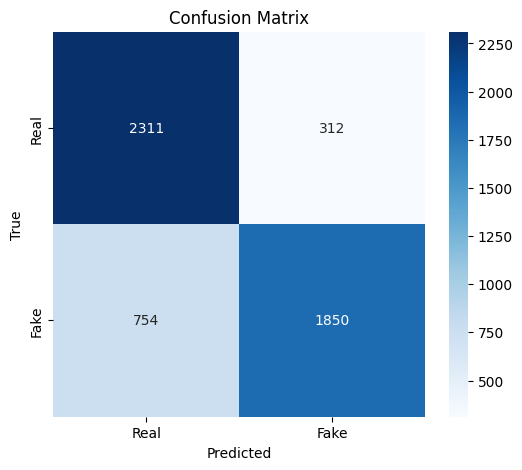

In [11]:
model_1, history_1 = run_experiment(path_dataset_1, dataset_name="Dataset 1")

STARTING EXPERIMENT: Dataset 2

--- Loading Data from: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 2/Data Set 2 ---
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,947,841 (129.50 MB)

 Trainable params: 33,945,857 (129.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


E0000 00:00:1764778039.980384      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 171s 134ms/step - accuracy: 0.5665 - loss: 0.8294 - val_accuracy: 0.5647 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.6300 - loss: 0.6440 - val_accuracy: 0.6081 - val_loss: 0.6547 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.6458 - loss: 0.6232 - val_accuracy: 0.6234 - val_loss: 0.6571 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.6710 - loss: 0.5997 - val_accuracy: 0.6873 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.7280 - loss: 0.5257 - val_accuracy: 0.7107 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.7644 - loss: 0.4732 - val_accuracy: 0.7396 - val_loss: 0.5044 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - acc

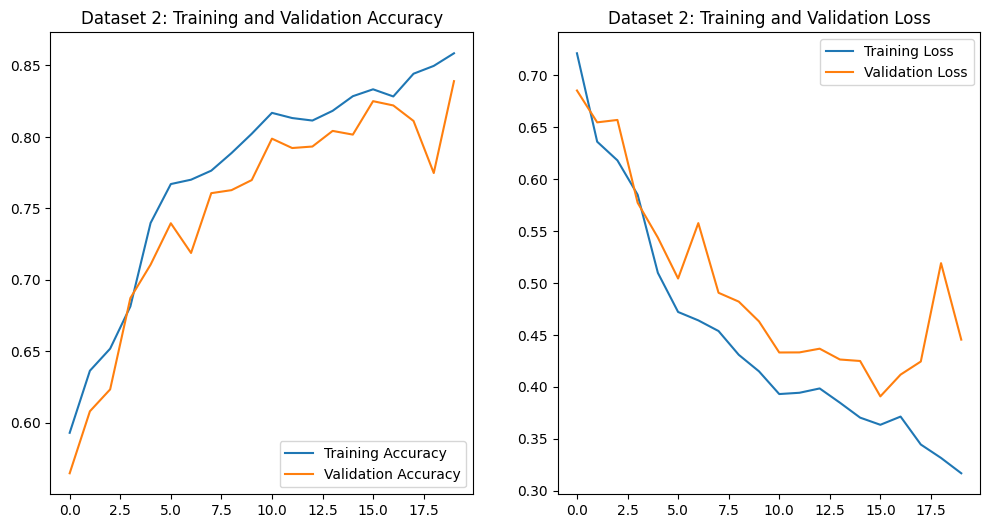


--- Evaluating Model ---
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7832 - loss: 0.4429
Test Loss: 0.4338
Test Accuracy: 0.7991

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.82      0.77      0.79      2623
    Fake (1)       0.78      0.83      0.80      2603

    accuracy                           0.80      5226
   macro avg       0.80      0.80      0.80      5226
weighted avg       0.80      0.80      0.80      5226

Confusion Matrix:


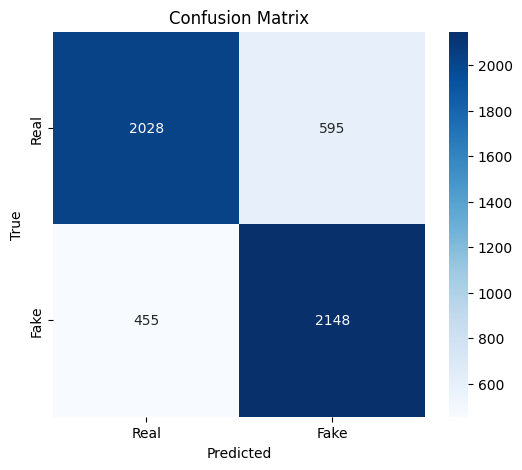

In [13]:
model_2, history_2 = run_experiment(path_dataset_2, dataset_name="Dataset 2")

STARTING EXPERIMENT: Dataset 3

--- Loading Data from: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 3/Data Set 3 ---
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,947,841 (129.50 MB)

 Trainable params: 33,945,857 (129.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


E0000 00:00:1764781222.157465      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 167s 130ms/step - accuracy: 0.6391 - loss: 0.7653 - val_accuracy: 0.5855 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.8336 - loss: 0.3685 - val_accuracy: 0.8498 - val_loss: 0.3511 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.8911 - loss: 0.2610 - val_accuracy: 0.8763 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.9057 - loss: 0.2282 - val_accuracy: 0.8839 - val_loss: 0.2815 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9136 - loss: 0.2150 - val_accuracy: 0.8313 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.9262 - loss: 0.1825 - val_accuracy: 0.8701 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - acc

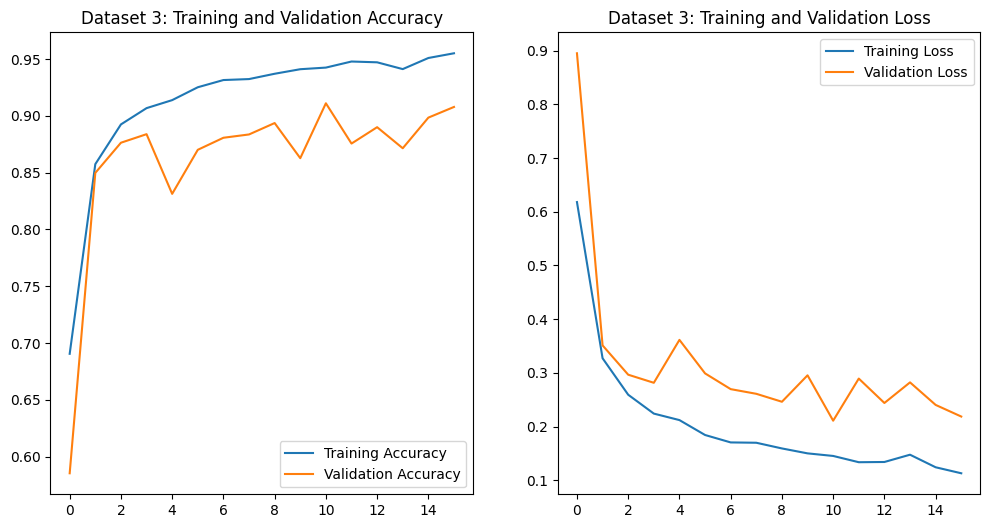


--- Evaluating Model ---
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5873 - loss: 1.0412
Test Loss: 0.9886
Test Accuracy: 0.6100

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.60      0.68      0.64      2623
    Fake (1)       0.63      0.54      0.58      2603

    accuracy                           0.61      5226
   macro avg       0.61      0.61      0.61      5226
weighted avg       0.61      0.61      0.61      5226

Confusion Matrix:


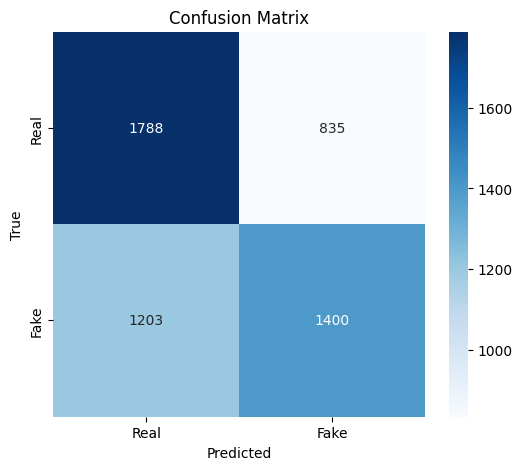

In [14]:
model_3, history_3 = run_experiment(path_dataset_3, dataset_name="Dataset 3")

STARTING EXPERIMENT: Dataset 4

--- Loading Data from: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 4/Data Set 4 ---
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,947,841 (129.50 MB)

 Trainable params: 33,945,857 (129.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


E0000 00:00:1764792379.049701      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 120ms/step - accuracy: 0.6880 - loss: 0.6914 - val_accuracy: 0.7883 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.8360 - loss: 0.3636 - val_accuracy: 0.8523 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.8975 - loss: 0.2453 - val_accuracy: 0.8448 - val_loss: 0.3331 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.9148 - loss: 0.2157 - val_accuracy: 0.8788 - val_loss: 0.2711 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9265 - loss: 0.1831 - val_accuracy: 0.8887 - val_loss: 0.2792 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9296 - loss: 0.1778 - val_accuracy: 0.8850 - val_loss: 0.2671 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - acc

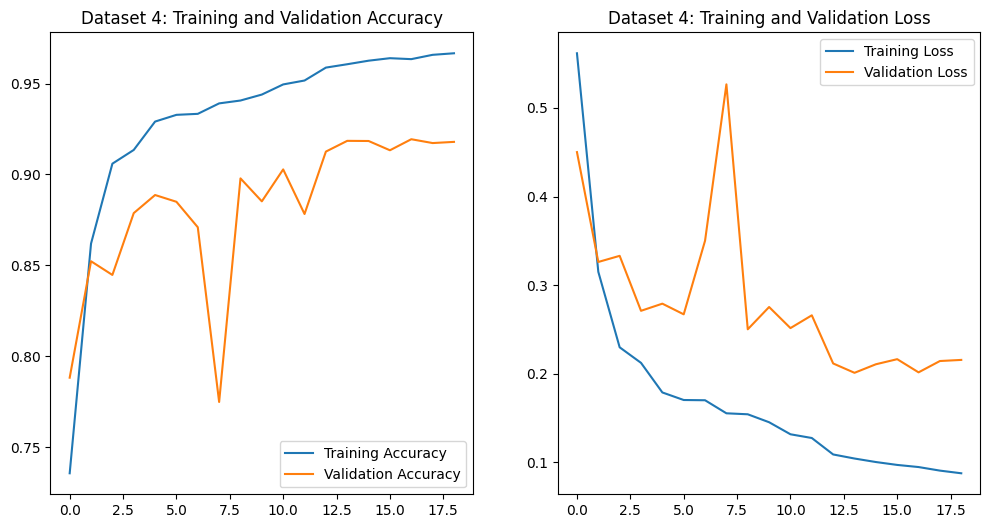


--- Evaluating Model ---
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8532 - loss: 0.3436
Test Loss: 0.2845
Test Accuracy: 0.8825

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.92      0.83      0.88      2623
    Fake (1)       0.85      0.93      0.89      2603

    accuracy                           0.88      5226
   macro avg       0.89      0.88      0.88      5226
weighted avg       0.89      0.88      0.88      5226

Confusion Matrix:


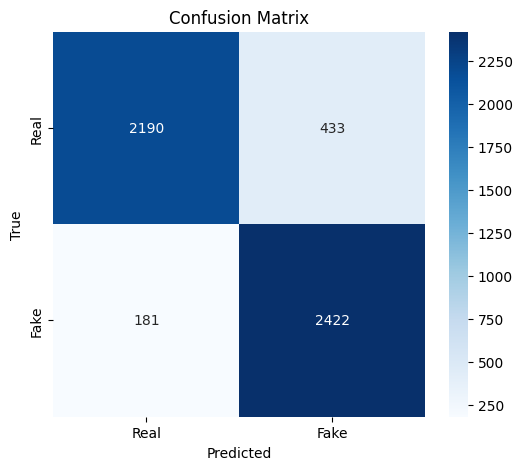

In [30]:
model_4, history_4 = run_experiment(path_dataset_4, dataset_name="Dataset 4")

## Load Combined Datasets

In [15]:
def load_combined_datasets(path_list):
    print(f"\n--- Loading and Combining {len(path_list)} Datasets ---")
    
    full_train_ds = None
    full_val_ds = None
    full_test_ds = None

    for data_path in path_list:
        print(f"Processing: {data_path}...")
        
        if not os.path.exists(data_path):
            print(f"Warning: Path not found {data_path}, skipping.")
            continue

        # Load partial datasets
        train_ds = tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_path, 'train'),
            labels='inferred',
            label_mode='binary',
            image_size=IMG_SIZE,
            interpolation='nearest',
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        val_ds = tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_path, 'validation'),
            labels='inferred',
            label_mode='binary',
            image_size=IMG_SIZE,
            interpolation='nearest',
            batch_size=BATCH_SIZE,
            shuffle=False
        )

        test_ds = tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_path, 'test'),
            labels='inferred',
            label_mode='binary',
            image_size=IMG_SIZE,
            interpolation='nearest',
            batch_size=BATCH_SIZE,
            shuffle=False
        )

        # Concatenate logic
        if full_train_ds is None:
            full_train_ds = train_ds
            full_val_ds = val_ds
            full_test_ds = test_ds
        else:
            full_train_ds = full_train_ds.concatenate(train_ds)
            full_val_ds = full_val_ds.concatenate(val_ds)
            full_test_ds = full_test_ds.concatenate(test_ds)

    # 1. Reduce shuffle buffer drastically (from 1000 to 50) 
    # This prevents holding too many batches in RAM at once
    full_train_ds = full_train_ds.shuffle(buffer_size=50)
    
    # 2. REMOVED .cache() 
    # We only keep .prefetch(). This loads data from disk as needed.
    full_train_ds = full_train_ds.prefetch(buffer_size=AUTOTUNE)
    full_val_ds = full_val_ds.prefetch(buffer_size=AUTOTUNE)
    full_test_ds = full_test_ds.prefetch(buffer_size=AUTOTUNE)

    print("--- Datasets Combined Successfully ---")
    return full_train_ds, full_val_ds, full_test_ds

## Function Pipeline

In [16]:
def run_experiment(path_list, dataset_name="Combined Datasets"):
    print(f"==========================================")
    print(f"STARTING EXPERIMENT: {dataset_name}")
    print(f"==========================================")

    # 1. Load Combined Data
    train_ds, val_ds, test_ds = load_combined_datasets(path_list)
    
    if train_ds is None: 
        print("Error: No datasets loaded.")
        return None, None

    # 2. Build Model
    model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # 3. Train
    history = train_model(model, train_ds, val_ds)

    # 4. Plot
    plot_history(history, dataset_name)

    # 5. Evaluate
    evaluate_model(model, test_ds)
    
    return model, history

## Define Combined Paths

In [17]:
# List of all dataset paths
all_dataset_paths = [
    '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 1/Data Set 1',
    '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 2/Data Set 2',
    '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 3/Data Set 3',
    '/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 4/Data Set 4'
]

# EXECUTION of Combined Datasets

STARTING EXPERIMENT: All 4 Datasets Merged

--- Loading and Combining 4 Datasets ---
Processing: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 1/Data Set 1...
Found 40002 files belonging to 2 classes.
Found 12360 files belonging to 2 classes.
Found 5227 files belonging to 2 classes.
Processing: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 2/Data Set 2...
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.
Processing: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 3/Data Set 3...
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.
Processing: /kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 4/Data Set 4...
Found 40000 files belonging to 2 classes.
Found 12356 files belonging to 2 classes.
Found 5226 files belonging to 2 classes.
--- Datasets Co

E0000 00:00:1764784861.057793      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/dropout_15_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5001/5001 ━━━━━━━━━━━━━━━━━━━━ 623s 123ms/step - accuracy: 0.6941 - loss: 0.6049 - val_accuracy: 0.7369 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 2/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 606s 121ms/step - accuracy: 0.8737 - loss: 0.2820 - val_accuracy: 0.8412 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 3/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 599s 119ms/step - accuracy: 0.8931 - loss: 0.2412 - val_accuracy: 0.8475 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 4/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 607s 121ms/step - accuracy: 0.8975 - loss: 0.2313 - val_accuracy: 0.8570 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 5/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 605s 121ms/step - accuracy: 0.9100 - loss: 0.2084 - val_accuracy: 0.8667 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 6/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 608s 121ms/step - accuracy: 0.9153 - loss: 0.1959 - val_accuracy: 0.8605 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 7/20
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 611s 122ms/step - acc

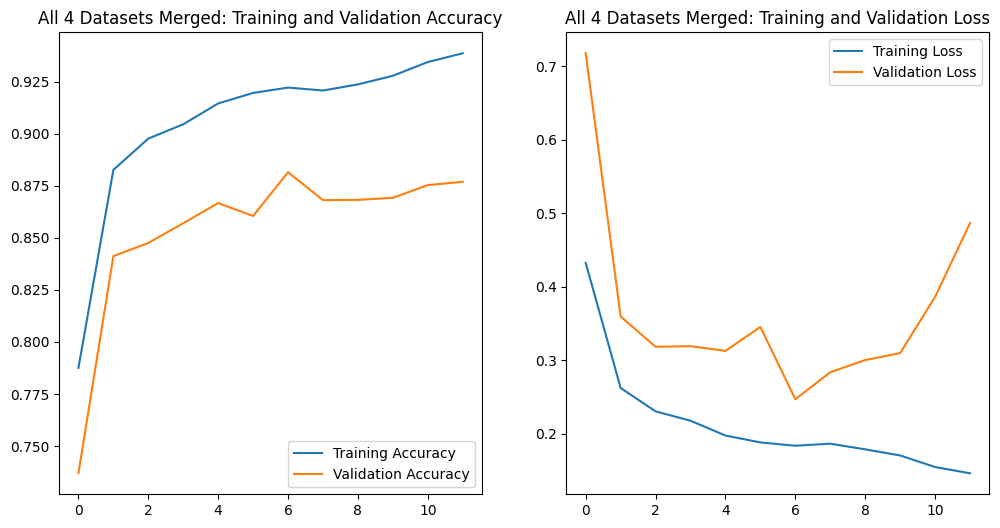


--- Evaluating Model ---
656/656 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.7988 - loss: 0.4081
Test Loss: 0.4329
Test Accuracy: 0.7835

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.76      0.83      0.79     10492
    Fake (1)       0.81      0.74      0.77     10413

    accuracy                           0.78     20905
   macro avg       0.79      0.78      0.78     20905
weighted avg       0.79      0.78      0.78     20905

Confusion Matrix:


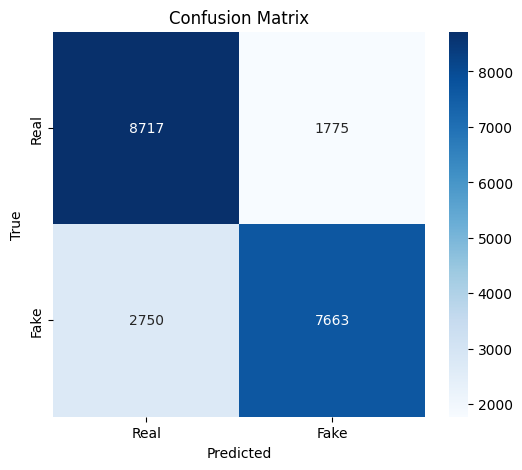

In [18]:
model_combined, history_combined = run_experiment(all_dataset_paths, dataset_name="All 4 Datasets Merged")